In [1]:
### Finance - Credit Risk Analysis

# Step 1: Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from imblearn.over_sampling import SMOTE


In [2]:
# Step 2: Load Data
data = pd.read_csv("C:\\Users\\hp\\Desktop\\Finance Project\\loandata.csv")


C:\Users\hp\AppData\Local\Temp\ipykernel_4564\1482192699.py:2: DtypeWarning: Columns (17,53,110,121,122,123,126,127,128,131,137,138,139) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv("C:\\Users\\hp\\Desktop\\Finance Project\\loandata.csv")


In [3]:

# Step 3: Data Overview
print(data.head())
print(f"Dataset contains {data.shape[0]} rows and {data.shape[1]} columns.")
print(data.info())


   loan_amnt  funded_amnt  funded_amnt_inv        term  int_rate  installment  \
0       2500         2500           2500.0   36 months     13.56        84.92   
1      30000        30000          30000.0   60 months     18.94       777.23   
2       5000         5000           5000.0   36 months     17.97       180.69   
3       4000         4000           4000.0   36 months     18.94       146.51   
4      30000        30000          30000.0   60 months     16.14       731.78   

  grade sub_grade       emp_title emp_length  ...  \
0     C        C1            Chef  10+ years  ...   
1     D        D2     Postmaster   10+ years  ...   
2     D        D1  Administrative    6 years  ...   
3     D        D2   IT Supervisor  10+ years  ...   
4     C        C4        Mechanic  10+ years  ...   

  hardship_payoff_balance_amount  hardship_last_payment_amount  \
0                            NaN                           NaN   
1                            NaN                           NaN

In [4]:
# Step 4: Handle Missing Values
# Check for null values and understand the structure of the data
print("Null Values in Each Column:")
print(data.isnull().sum())


Null Values in Each Column:
loan_amnt                      0
funded_amnt                    0
funded_amnt_inv                0
term                           0
int_rate                       0
                          ...   
settlement_status        1033780
settlement_date          1033780
settlement_amount        1033780
settlement_percentage    1033780
settlement_term          1033780
Length: 143, dtype: int64


In [5]:
# Drop unnecessary or redundant columns like id, member_id, and url
columns_to_drop = ['id', 'member_id', 'url']
data.drop(columns=columns_to_drop, axis=1, inplace=True)
print(f"Dropped columns: {columns_to_drop}")


KeyError: "['id', 'member_id'] not found in axis"

In [6]:
# Drop columns with too many missing values
missing_threshold = 0.3
missing_percentages = data.isnull().mean()
columns_to_drop = missing_percentages[missing_percentages > missing_threshold].index
print(f"Dropping columns with > {missing_threshold*100}% missing values: {columns_to_drop.tolist()}")
data.drop(columns=columns_to_drop, axis=1, inplace=True)


Dropping columns with > 30.0% missing values: ['url', 'desc', 'mths_since_last_delinq', 'mths_since_last_record', 'next_pymnt_d', 'mths_since_last_major_derog', 'annual_inc_joint', 'dti_joint', 'verification_status_joint', 'mths_since_recent_bc_dlq', 'mths_since_recent_revol_delinq', 'revol_bal_joint', 'sec_app_earliest_cr_line', 'sec_app_inq_last_6mths', 'sec_app_mort_acc', 'sec_app_open_acc', 'sec_app_revol_util', 'sec_app_open_act_il', 'sec_app_num_rev_accts', 'sec_app_chargeoff_within_12_mths', 'sec_app_collections_12_mths_ex_med', 'sec_app_mths_since_last_major_derog', 'hardship_type', 'hardship_reason', 'hardship_status', 'deferral_term', 'hardship_amount', 'hardship_start_date', 'hardship_end_date', 'payment_plan_start_date', 'hardship_length', 'hardship_dpd', 'hardship_loan_status', 'orig_projected_additional_accrued_interest', 'hardship_payoff_balance_amount', 'hardship_last_payment_amount', 'debt_settlement_flag_date', 'settlement_status', 'settlement_date', 'settlement_amoun

In [8]:
# Impute missing values for numeric columns
for col in data.select_dtypes(include=['float64', 'int64']).columns:
    data[col] = data[col].fillna(data[col].median())


In [9]:
# Fill missing values for categorical columns
for col in data.select_dtypes(include=['object']).columns:
    data[col] = data[col].fillna(data[col].mode()[0])


In [10]:
# Step 5: Feature Engineering
# Convert target variable 'loan_status' to binary (1 = Default, 0 = Non-Default)
def map_loan_status(status):
    if status in ['Charged Off', 'Default', 'Late (31-120 days)']:
        return 1
    else:
        return 0

data['loan_status_binary'] = data['loan_status'].apply(map_loan_status)
data.drop('loan_status', axis=1, inplace=True)


C:\Users\hp\AppData\Local\Temp\ipykernel_4564\3198887906.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data['loan_status_binary'] = data['loan_status'].apply(map_loan_status)


In [11]:
# Encode categorical variables
categorical_cols = data.select_dtypes(include=['object']).columns
for col in categorical_cols:
    data[col] = pd.factorize(data[col])[0]


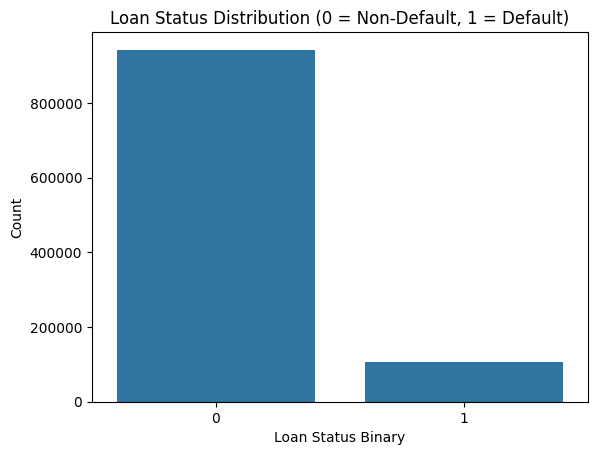

In [12]:
# Step 6: Exploratory Data Analysis
# Target variable distribution
sns.countplot(x='loan_status_binary', data=data)
plt.title('Loan Status Distribution (0 = Non-Default, 1 = Default)')
plt.xlabel('Loan Status Binary')
plt.ylabel('Count')
plt.show()


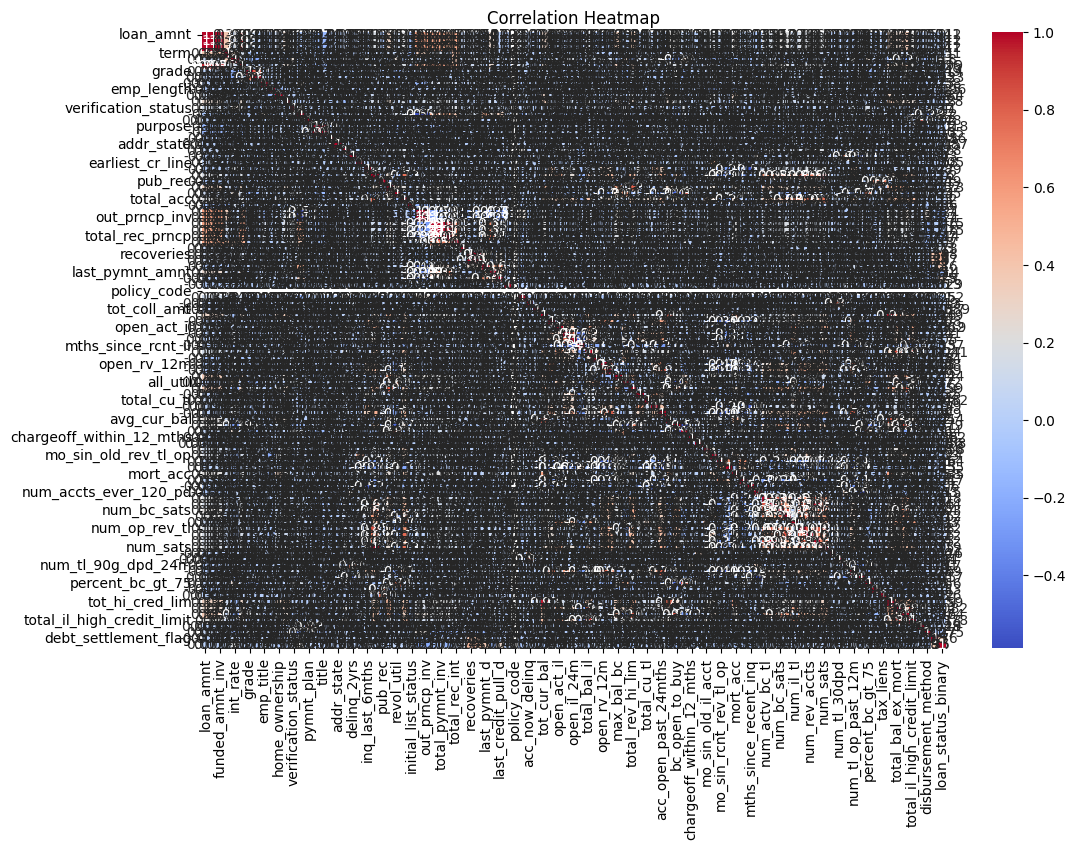

In [13]:
# Correlation heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(data.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()


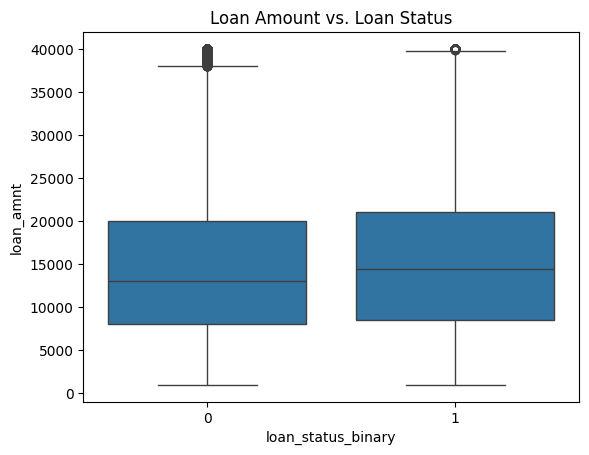

In [14]:
# Boxplot for loan amount vs loan status
sns.boxplot(x='loan_status_binary', y='loan_amnt', data=data)
plt.title('Loan Amount vs. Loan Status')
plt.show()


In [15]:
# Step 7: Train-Test Split
X = data.drop('loan_status_binary', axis=1)
y = data['loan_status_binary']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


In [16]:
# Step 8: Handle Class Imbalance with SMOTE
smote = SMOTE(random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)


In [18]:
# Step 9: Train Models
# Random Forest
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)


RandomForestClassifier(random_state=42)

In [19]:
# XGBoost
xgb_model = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')
xgb_model.fit(X_train, y_train)


C:\Users\hp\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [03:25:25] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, random_state=42, ...)

In [20]:
# Step 10: Model Evaluation
# Random Forest Evaluation
y_pred_rf = rf_model.predict(X_test)
print("Random Forest Report:")
print(classification_report(y_test, y_pred_rf))


Random Forest Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    282557
           1       1.00      0.97      0.98     32016

    accuracy                           1.00    314573
   macro avg       1.00      0.98      0.99    314573
weighted avg       1.00      1.00      1.00    314573



In [21]:
# XGBoost Evaluation
y_pred_xgb = xgb_model.predict(X_test)
print("XGBoost Report:")
print(classification_report(y_test, y_pred_xgb))


XGBoost Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    282557
           1       1.00      0.98      0.99     32016

    accuracy                           1.00    314573
   macro avg       1.00      0.99      0.99    314573
weighted avg       1.00      1.00      1.00    314573



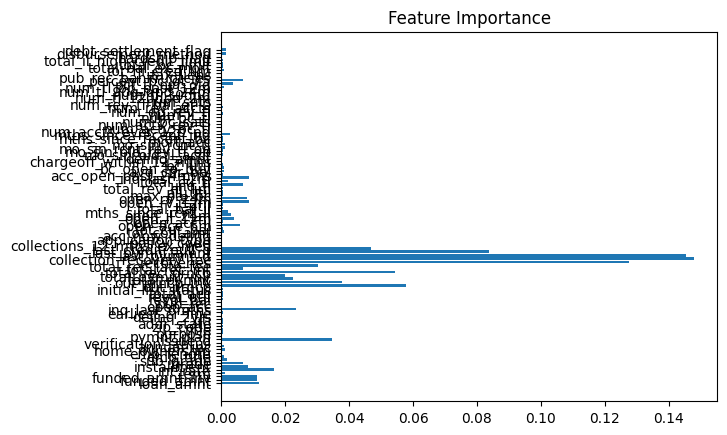

In [22]:
# Step 11: Feature Importance (Random Forest)
importances = rf_model.feature_importances_
plt.barh(X.columns, importances)
plt.title("Feature Importance")
plt.show()
